In [1]:
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display

#to play audio
import IPython.display as ipd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import shutil
from tensorflow.keras.metrics import AUC
# if os.path.exists('./prep/'):
#     shutil.rmtree('./prep/')
label_csv = '../input/environmental-sound-classification-50/esc50.csv'
audio_fpath = "../input/environmental-sound-classification-50/audio/audio/44100/"

In [2]:
class AudioAugmentation:  
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    
    def shift(self, data):
        return np.roll(data, 44100)
    
    def stretch(self, data, rate=1):
        input_length = 220500
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data

In [3]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)

In [4]:
audio_fpath = "../input/environmental-sound-classification-50/audio/audio/44100/"
audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))
df = pd.read_csv(label_csv, usecols=['filename', 'target', 'category'])

df.head()

No. of .wav files in audio folder =  2000


,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,14,chirping_birds
2,1-100210-A-36.wav,36,vacuum_cleaner
3,1-100210-B-36.wav,36,vacuum_cleaner
4,1-101296-A-19.wav,19,thunderstorm


In [5]:
aa = AudioAugmentation()
trainframe = []
for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_fpath), str(row['filename']))
    dirname='./prep/'
    if not os.path.exists(dirname):
        create_dir(dirname)
    try:
        y, sr = librosa.load(file_name)
    except:
        print(str(row['filename'])+ ' is not a valid file')
    else: 
        
        file_name = os.path.join(os.path.abspath(audio_fpath),str(row['category'] + '/'), str(row['filename']))
        mfcc = []
        for i in range(8):
            out_file = dirname+ row['filename'].split('.wav')[0] + '.' + str(i) + '.png'
            file_name=(out_file.split('/')[-1])
            label=(row['category'])
            trainframe.append([file_name, label])
            if i == 1 or i >3:
                feature = aa.add_noise(y)
            if i%3 == 2 or i == 7:
                feature = aa.shift(y)
            if i%3 == 0 or i == 7:
                feature = aa.stretch(y, rate=1.25)
            if os.path.exists(out_file):
                continue
            mfcc = librosa.feature.mfcc(y = feature, sr = sr, n_mfcc=20)
            mfcc = np.subtract(mfcc, np.mean(mfcc))
            mfcc_gram = librosa.amplitude_to_db(mfcc, ref=np.min)
            librosa.display.specshow(mfcc_gram, sr=sr)
            plt.colorbar(format='%+2.0f dB')
            plt.savefig(out_file)
            plt.clf()

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Pass rate=1.25 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Pass rate=1.25 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  if sys.path[0] == "":
2000it [11:41,  2.85it/s]


In [6]:
feature_df = pd.DataFrame(trainframe, columns=['filename','class'])

feature_df.head()

,filename,class
0,1-100032-A-0.0.png,dog
1,1-100032-A-0.1.png,dog
2,1-100032-A-0.2.png,dog
3,1-100032-A-0.3.png,dog
4,1-100032-A-0.4.png,dog


In [7]:
x = np.array(feature_df['filename'].tolist())

x.shape

(16000,)

In [8]:
target = np.array(feature_df['class'].tolist())

In [9]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(16000, 50)


,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,...,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data = feature_df
data['filename'] = feature_df['filename'].apply(lambda x:x.replace('.wav', '.png'))
# data['temp'] = feature_df['class'] +'/' + feature_df['filename'] 
# data['path'] = data['temp']
data = data[['filename', 'class']]
data.head()

,filename,class
0,1-100032-A-0.0.png,dog
1,1-100032-A-0.1.png,dog
2,1-100032-A-0.2.png,dog
3,1-100032-A-0.3.png,dog
4,1-100032-A-0.4.png,dog


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    y_new, 
    test_size=0.2, 
    random_state=15
)
datagen = ImageDataGenerator()
it = datagen.flow_from_dataframe(
    data,
    x_col="filename",
    y_col='class',
    batch_size=1, 
    directory='./prep/')

print(it.class_indices.keys())
inp = Input(shape = next(it)[0][0].shape)
print(inp)
model = ResNet50(
    include_top=False,
    weights="imagenet",
    classes=50,
    input_tensor = inp
)

print(type(x), type(sr))
print(x.shape, sr)

Found 16000 validated image filenames belonging to 50 classes.
dict_keys(['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind'])


In [ ]:
for layer in model.layers:
    layer.trainable=False

In [ ]:
new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(50, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
new_model.compile(
    loss = 'categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy', AUC()]
)

In [21]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=15, 
    min_delta = 0.001
)

history = new_model.fit(
    datagen.flow_from_dataframe(
        X_train,
        x_col="filename",
        y_col="class",
        batch_size=512, 
        directory = './prep'
    ),
    validation_data=datagen.flow_from_dataframe(
        X_test,
        x_col="filename",
        y_col="class",
        batch_size=512,
        directory = './prep'),
    epochs=500,
    callbacks=[es]
)
new_model.save('ResNet50_ESC50_Trained_model')

Found 12800 validated image filenames belonging to 50 classes.
Found 3200 validated image filenames belonging to 50 classes.
Epoch 1/500
25/25 [==============================] - 101s 4s/step - loss: 0.3012 - accuracy: 0.9077 - auc: 0.9967 - val_loss: 0.3208 - val_accuracy: 0.9241 - val_auc: 0.9912


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f7d1bea77a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 2/500
25/25 [==============================] - 101s 4s/step - loss: 0.2991 - accuracy: 0.9070 - auc: 0.9971 - val_loss: 0.3276 - val_accuracy: 0.9234 - val_auc: 0.9909
Epoch 3/500
25/25 [==============================] - 99s 4s/step - loss: 0.2939 - accuracy: 0.9120 - auc: 0.9966 - val_loss: 0.3550 - val_accuracy: 0.9244 - val_auc: 0.9896
Epoch 4/500
25/25 [==============================] - 100s 4s/step - loss: 0.3121 - accuracy: 0.9030 - auc: 0.9965 - val_loss: 0.3179 - val_accuracy: 0.9216 - val_auc: 0.9924
Epoch 5/500
25/25 [==============================] - 100s 4s/step - loss: 0.3007 - accuracy: 0.9080 - auc: 0.9969 - val_loss: 0.3306 - val_accuracy: 0.9237 - val_auc: 0.9912
Epoch 6/500
12/25 [=============>................] - ETA: 40s - loss: 0.2902 - accuracy: 0.9100 - auc: 0.9970

KeyboardInterrupt: 

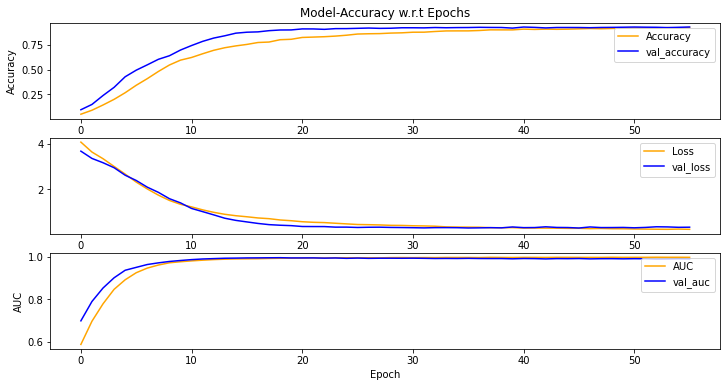

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax3.plot(history.history['auc'], color='orange', label='AUC')
ax3.plot(history.history['val_auc'], color='blue', label='val_auc')
ax3.set_xlabel("Epoch")
ax3.set_ylabel("AUC")
ax3.legend(loc='upper right')
plt.savefig('model_acc_ResNet50_ESC50.png')

In [16]:
test_dat = ImageDataGenerator()
test_gen = test_dat.flow_from_dataframe(data, 
                                        x_col="filename", 
                                        y_col="class", 
                                        batch_size=100, 
                                        class_mode='categorical',
                                        shuffle = False,
                                        directory = './prep')

labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen,steps =16000)
print(test_gen.class_indices.keys())

Found 16000 validated image filenames belonging to 50 classes.
dict_keys(['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind'])


In [17]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [18]:
y_true = np.argmax(np.array(labels), axis=1)
m = AUC()
m.update_state(labels, y_pred)
print(m.result())

tf.Tensor(0.9984401, shape=(), dtype=float32)


In [19]:
print(np.mean(y_pred_classes == y_true))

0.9861875


<Figure size 432x288 with 0 Axes>

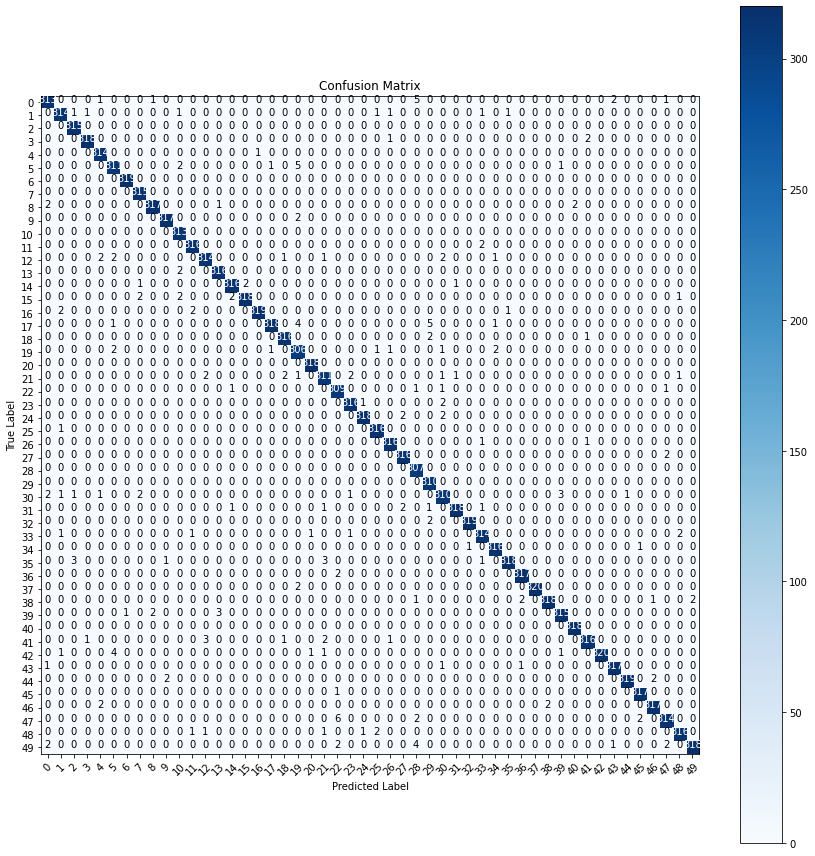

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_classes, y_true,)
import itertools
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(50)))
plt.xticks(tick_marks, range(50), rotation=45)
plt.yticks(tick_marks, range(50))
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('con_matrix_ResNet50_ESC50.png')